Вам нужно проанализировать биоинформатический датасет по пространственной транскриптомике пациентов с плоскоклеточным раком. В нем клетки (колонка cell_type) объединены в микроокружения (колонка cell_interaction) в зависимости от взаимодействия этих клеток. Вашей основной задачей будет поиск отличий в организации микроокружения у пожилых и молодых пациентов (колонка age_group).

Также в датасете есть следующие колонки:

distance_to_vasculature — расстояние до ближайших сосудов;
distance_to_largest_cell — расстояние до ближайшей крупной клетки;
immune_marker_1 — экспрессия иммунного маркера 1 в данной клетке;
immune_marker_2 — экспрессия иммунного маркера 2 в данной клетке;
cell_type — тип клетки;
area_of_cell — размер клетки;
case_id — уникальный ID пациента.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
# Загрузка данных
data = pd.read_csv("asset-v1_SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv")


In [ ]:
data.head()

,distance_to_vasculature,distance_to_largest_cell,immune_marker_1,immune_marker_2,cell_interaction,cell_type,case_id,area_of_cell,age_group
0,988.509380,612.076506,10.803755,187.998971,community_1,Stroma cells,891,185,elder_group
1,787.852379,637.787202,11.749179,155.357076,community_1,Stroma cells,891,209,elder_group
2,960.635580,700.283468,15.124372,182.626888,community_2,Stroma cells,891,254,elder_group
3,702.033032,676.409695,14.221883,158.381917,community_3,Unclassified,891,156,elder_group
4,830.399371,863.269930,19.978977,159.071269,community_3,Unclassified,891,194,elder_group


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269442 entries, 0 to 269441
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   distance_to_vasculature   269442 non-null  float64
 1   distance_to_largest_cell  269442 non-null  float64
 2   immune_marker_1           269442 non-null  float64
 3   immune_marker_2           269442 non-null  float64
 4   cell_interaction          269442 non-null  object 
 5   cell_type                 269442 non-null  object 
 6   case_id                   269442 non-null  int64  
 7   area_of_cell              269442 non-null  int64  
 8   age_group                 269442 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 18.5+ MB


In [ ]:
df = pd.DataFrame(data)

# Преобразование case_id в строку
df['case_id'] = df['case_id'].astype(str)

                                           Задачи:

1) Есть ли стат-значимость между типом клетки и:

а) Размером клетки (area_of_cell), добавьте hue по возрастным группам.



Для определения статистической значимости связи между типом клетки и размером клетки (area_of_cell) с учетом возрастных групп, можно следовать следующему алгоритму действий:

Визуализация данных:
Построить диаграмму размаха (боксплот) или swarplot для переменных cell_type (тип клетки) и area_of_cell (размер клетки). Использовать параметр hue='age_group' для разделения данных по возрастным группам на том же графике. Это позволит визуально оценить распределение размеров клеток для различных типов клеток и возрастных групп. Проверка предпосылок статистического теста

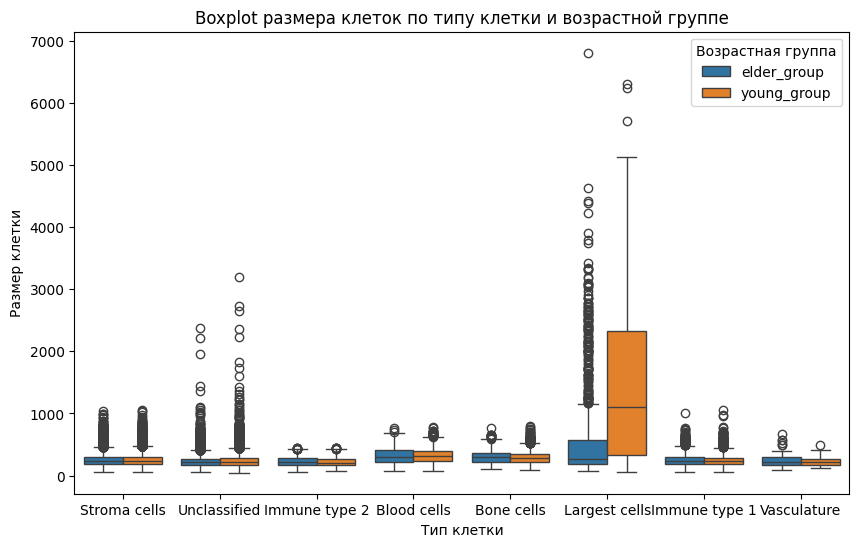

In [ ]:
# Визуализация данных
plt.figure(figsize=(10, 6))
sns.boxplot(x="cell_type", y="area_of_cell", hue="age_group", data=data)
plt.title("Boxplot размера клеток по типу клетки и возрастной группе")
plt.xlabel("Тип клетки")
plt.ylabel("Размер клетки")
plt.legend(title="Возрастная группа")
plt.show()




На графике boxplot мы наблюдаем большое количество выбросов, что может быть быть обусловленно наличием плоскоклеточного рака.  Особенно много выбросов мы наблюдаем у типа клеток Unclassified, Large и stroma. В типе stroma cells это может быть связано с усиленным разростанием миофибробластов  с гладкомышечными актиновыми филаментами при плоскоклеточном раке. В типе клеток Blood cell и Vasculature выбросов гораздо меньше, это может быть связанно с тем, что метастазирование является более характерной чертой для этого типа рака,  хотя ангиогенез также может присутствовать при плоскоклеточном раке.Также средний размер клеток в группе пожилых людей (elder_group) может быть меньше из-за естественного старения организма и связанных с ним процессов, таких как уменьшение клеточного размера или снижение активности клеток. Различия в дисперсии и в средних значениях  в типе клеток Large могут отражать разные биологические характеристики клеток в разных возрастных группах.  В любом случае для рака характерно наличие увеличенных клеток в различных возрастных группах, что мы и наблюдаем на графике boxplot.

Проверим нормальность распределения переменной area_of_cell для каждой комбинации cell_type и age_group. Это можно сделать с помощью гистограмм, графиков квантиль-квантиль или статистических тестов на нормальность (например, тест Шапиро-Уилка).

In [ ]:
# Итерация по каждой комбинации cell_type и age_group
for (cell_type, age_group), group_data in data.groupby(['cell_type', 'age_group']):
    print(f"Тест Шапиро-Уилка для {cell_type} в группе {age_group}:")

    # Проведение теста на нормальность
    stat, p_value = shapiro(group_data['area_of_cell'])

    # Вывод результатов теста
    print(f"Статистика теста: {stat}, p-value: {p_value}")

    # Оценка нормальности распределения
    if p_value > 0.05:
        print("Распределение является нормальным (p > 0.05)")
    else:
        print("Распределение не является нормальным (p <= 0.05)")

Тест Шапиро-Уилка для Blood cells в группе elder_group:
Статистика теста: 0.9638803601264954, p-value: 5.183330986646695e-10
Распределение не является нормальным (p <= 0.05)
Тест Шапиро-Уилка для Blood cells в группе young_group:
Статистика теста: 0.9703012704849243, p-value: 2.1042767963977946e-21
Распределение не является нормальным (p <= 0.05)
Тест Шапиро-Уилка для Bone cells в группе elder_group:
Статистика теста: 0.9468902945518494, p-value: 1.2447218256106396e-10
Распределение не является нормальным (p <= 0.05)
Тест Шапиро-Уилка для Bone cells в группе young_group:
Статистика теста: 0.934744656085968, p-value: 8.514108968429559e-30
Распределение не является нормальным (p <= 0.05)
Тест Шапиро-Уилка для Immune type 1 в группе elder_group:
Статистика теста: 0.9030000567436218, p-value: 1.4941454786522319e-30
Распределение не является нормальным (p <= 0.05)
Тест Шапиро-Уилка для Immune type 1 в группе young_group:
Статистика теста: 0.8988940119743347, p-value: 1.401298464324817e-45
Р

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Выбор статистического теста:

Результаты теста Шапиро-Уилка указывают на то, что распределения переменной area_of_cell для каждой комбинации cell_type и age_group не являются нормальными (p-value <= 0.05) для всех групп. Это означает, что мы не можем использовать параметрические статистические тесты, которые предполагают нормальность данных, для проверки статистической значимости различий между группами.
Для анализа различий между группами, учитывая отсутствие нормальности распределения, можно использовать непараметрические методы, такие как тест Краскела-Уоллиса с последующим попарным сравнением с помощью коррекции на множественные сравнения, например, методом Данна или методом Бенджамини-Хохберга.

Провести выбранный статистический тест (двухфакторный дисперсионный анализ или критерий Краскела-Уоллиса) для переменных cell_type, age_group и area_of_cell. Получить значение статистики теста и соответствующее значение p-value. Интерпретация результатов:
Если значение p-value меньше принятого уровня значимости (обычно 0.05), то можно сделать вывод о наличии статистически значимой связи между типом клетки и размером клетки с учетом возрастных групп. В случае двухфакторного дисперсионного анализа, можно также проанализировать значимость взаимодействия факторов cell_type и age_group.

In [ ]:
# Группировка данных по типу клетки и возрастной группе
cell_type_groups = data.groupby(['cell_type', 'age_group'])['area_of_cell'].apply(list)

# Проведение теста Краскела-Уоллиса для каждой группы типа клетки
for cell_type, group_data in cell_type_groups.items():
    result = kruskal(*group_data)
    print(f"Статистическая значимость для типа клетки '{cell_type}':")
    print(f"Статистика теста: {result.statistic}")
    print(f"p-value: {result.pvalue}")
    if result.pvalue < 0.05:
        print("Есть статистически значимые различия")
    else:
        print("Нет статистически значимых различий")
    print()

Статистическая значимость для типа клетки '('Blood cells', 'elder_group')':
Статистика теста: 519.9999999999998
p-value: 0.4917527086490185
Нет статистически значимых различий

Статистическая значимость для типа клетки '('Blood cells', 'young_group')':
Статистика теста: 2296.0
p-value: 0.49607517800512685
Нет статистически значимых различий

Статистическая значимость для типа клетки '('Bone cells', 'elder_group')':
Статистика теста: 389.9999999999999
p-value: 0.49047678176972465
Нет статистически значимых различий

Статистическая значимость для типа клетки '('Bone cells', 'young_group')':
Статистика теста: 2162.999999999999
p-value: 0.49595631073090335
Нет статистически значимых различий

Статистическая значимость для типа клетки '('Immune type 1', 'elder_group')':
Статистика теста: 1581.9999999999995
p-value: 0.49527171538128806
Нет статистически значимых различий

Статистическая значимость для типа клетки '('Immune type 1', 'young_group')':
Статистика теста: 3991.0
p-value: 0.4970231

Далее опционально
При необходимости можно провести post-hoc тесты (например, тест Тьюки или тест Данна) для множественных сравнений между группами.

Тест Краскела-Уоллиса дал неожиданные результаты, это может быть вызвано такими факторами как: неравномерная дисперсия, выбросы, неоднородность групп и нарушение предположений. Результаты теста Краскела-Уоллиса показывают, что нет статистически значимых различий между типом клетки и размером клетки (area_of_cell) ни для одной из возрастных групп. Это означает, что с учетом выборки данных у нас нет достаточных доказательств, чтобы отвергнуть нулевую гипотезу о равенстве средних значений размера клеток для различных типов клеток в каждой возрастной группе.
Таким образом, мы не можем сделать вывод о наличии статистически значимой разницы в размере клеток между типами клеток в каждой возрастной группе на основе представленных данных.
Поэтому мы проведем дополнительно  тест Данна это может помочь более точно определить статистические различия между группами.

In [ ]:
!pip install scikit-posthocs

In [ ]:
import scipy.stats as sp
from scikit_posthocs import posthoc_dunn
# Проведение теста Данна
dunn_result = posthoc_dunn(data, val_col='area_of_cell', group_col='cell_type', p_adjust='bonferroni')

# Вывод результатов
print("Результаты теста Данна:")
print(dunn_result)

Результаты теста Данна:
                 Blood cells     Bone cells  Immune type 1  Immune type 2  \
Blood cells     1.000000e+00   3.557602e-11  5.168870e-183   0.000000e+00   
Bone cells      3.557602e-11   1.000000e+00   9.965097e-87  1.072387e-229   
Immune type 1  5.168870e-183   9.965097e-87   1.000000e+00   2.642186e-42   
Immune type 2   0.000000e+00  1.072387e-229   2.642186e-42   1.000000e+00   
Largest cells   2.943191e-06   3.969099e-30  1.403725e-217   0.000000e+00   
Stroma cells   4.902874e-225   1.977730e-95   3.634079e-04  1.000979e-243   
Unclassified    0.000000e+00  8.048447e-248   4.069544e-47   1.000000e+00   
Vasculature     5.602506e-19   8.534627e-11   1.000000e+00   1.000000e+00   

               Largest cells   Stroma cells   Unclassified   Vasculature  
Blood cells     2.943191e-06  4.902874e-225   0.000000e+00  5.602506e-19  
Bone cells      3.969099e-30   1.977730e-95  8.048447e-248  8.534627e-11  
Immune type 1  1.403725e-217   3.634079e-04   4.069544e-4

На основе результатов теста Данна можно сделать следующие вывод, что между типами клеток существуют статистически значимые различия в размере клеток:

Клетки крови (Blood cells), Костные клетки (Bone cells), Иммунотип 1 (Immune type 1), Иммунотип 2 (Immune type 2), и Крупные клетки (Largest cells) имеют статистически значимые различия между собой.

Стромальные клетки (Stroma cells) и Неклассифицированные (Unclassified) также имеют статистически значимые различия между собой.

Клетки сосудистой ткани (Vasculature) не показали статистически значимых различий с другими типами клеток.

Клетки крови (Blood cells)
Костные клетки (Bone cells)
Иммунотип 1 (Immune type 1)
Иммунотип 2 (Immune type 2)
Крупные клетки (Largest cells)
Стромальные клетки (Stroma cells)
Неклассифицированные (Unclassified)
Эти типы клеток демонстрируют значимые различия как внутри каждой возрастной группы, так и между группами.

Результаты теста подтверждают, что размеры клеток значимо различаются между типами клеток.

б) Есть ли стат-значимость между типом клетки и экспрессией иммунных маркеров (immune_marker_1, immune_marker_2), добавьте hue по возрастным группам.

Визуализация данных с помощью boxplot или swarplot, используя immune_marker_1 и immune_marker_2 в качестве переменных по оси y и cell_type в качестве переменной по оси x. Добавьте hue по возрастным группам.

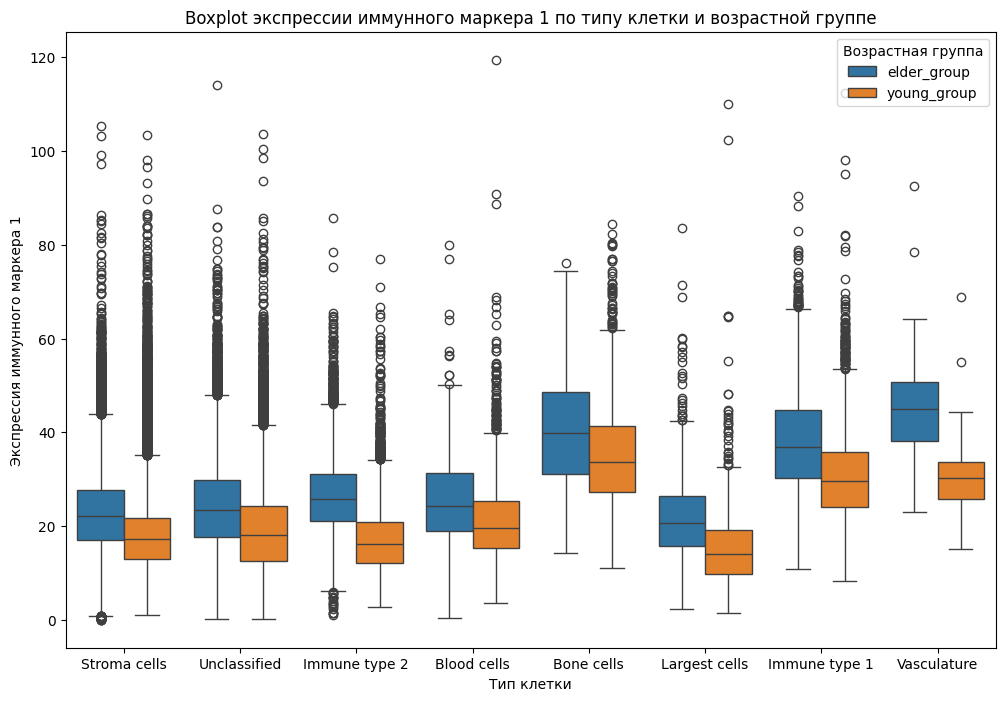

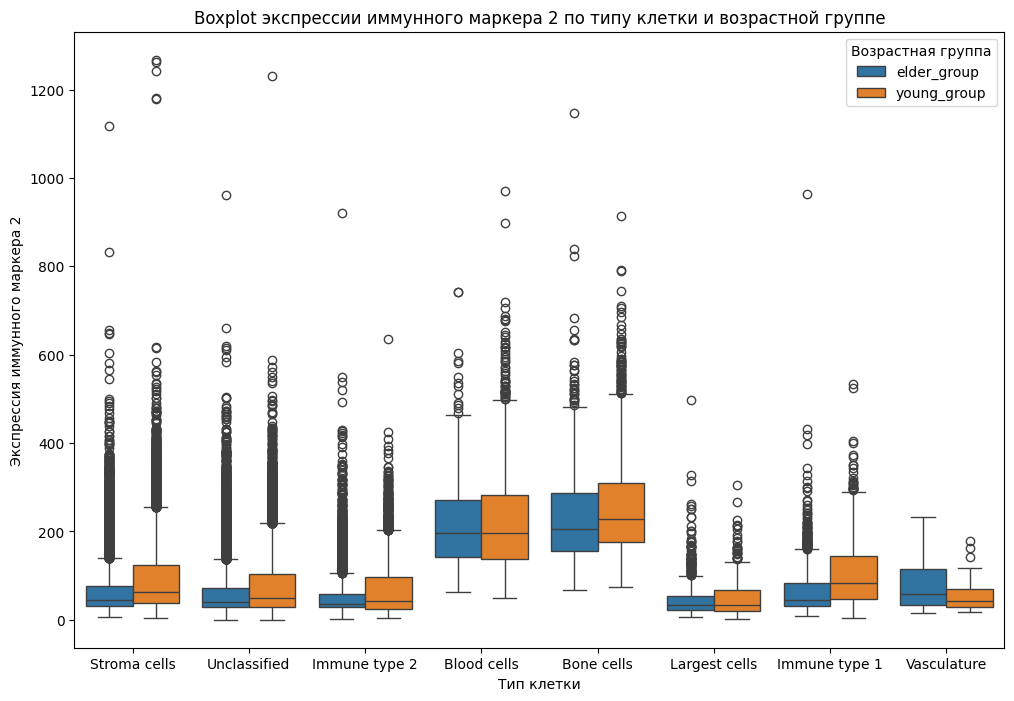

In [ ]:
# Визуализация данных
plt.figure(figsize=(12, 8))
sns.boxplot(x="cell_type", y="immune_marker_1", hue="age_group", data=data)
plt.title("Boxplot экспрессии иммунного маркера 1 по типу клетки и возрастной группе")
plt.xlabel("Тип клетки")
plt.ylabel("Экспрессия иммунного маркера 1")
plt.legend(title="Возрастная группа")
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x="cell_type", y="immune_marker_2", hue="age_group", data=data)
plt.title("Boxplot экспрессии иммунного маркера 2 по типу клетки и возрастной группе")
plt.xlabel("Тип клетки")
plt.ylabel("Экспрессия иммунного маркера 2")
plt.legend(title="Возрастная группа")
plt.show()

Проверка предположений для выбранного статистического теста. Для анализа экспрессии иммунных маркеров можно использовать однофакторный дисперсионный анализ (ANOVA) или его непараметрический аналог (Краскела-Уоллиса), если предположения ANOVA нарушены.

Для ANOVA: проверьте нормальность распределения остатков и гомогенность дисперсий.
Для Краскела-Уоллиса: этот тест не требует предположений о нормальности и гомогенности дисперсий.

Так как на графиках присутствует неоднородность дисперсии, применим тест Краскела-Уоллиса.

Выполните соответствующий статистический тест для выявления различий в экспрессии иммунных маркеров между типами клеток и возрастными группами.
Для ANOVA: проведите двухфакторный дисперсионный анализ с cell_type и age_group в качестве факторов (отдельно для immune_marker_1 и immune_marker_2).
Для Краскела-Уоллиса: проведите тест Краскела-Уоллиса для cell_type и age_group по отдельности (отдельно для immune_marker_1 и immune_marker_2).

In [ ]:
# Проведение теста Краскела-Уоллиса для каждого иммунного маркера
result_marker_1 = kruskal(data[data['cell_type'] == 'Blood cells']['immune_marker_1'],
                           data[data['cell_type'] == 'Bone cells']['immune_marker_1'],
                           data[data['cell_type'] == 'Immune type 1']['immune_marker_1'],
                           data[data['cell_type'] == 'Immune type 2']['immune_marker_1'],
                           data[data['cell_type'] == 'Largest cells']['immune_marker_1'],
                           data[data['cell_type'] == 'Stroma cells']['immune_marker_1'],
                           data[data['cell_type'] == 'Unclassified']['immune_marker_1'],
                           data[data['cell_type'] == 'Vasculature']['immune_marker_1'])

result_marker_2 = kruskal(data[data['cell_type'] == 'Blood cells']['immune_marker_2'],
                           data[data['cell_type'] == 'Bone cells']['immune_marker_2'],
                           data[data['cell_type'] == 'Immune type 1']['immune_marker_2'],
                           data[data['cell_type'] == 'Immune type 2']['immune_marker_2'],
                           data[data['cell_type'] == 'Largest cells']['immune_marker_2'],
                           data[data['cell_type'] == 'Stroma cells']['immune_marker_2'],
                           data[data['cell_type'] == 'Unclassified']['immune_marker_2'],
                           data[data['cell_type'] == 'Vasculature']['immune_marker_2'])

# Вывод результатов теста
print("Статистическая значимость между типом клетки и экспрессией иммунного маркера 1:")
print("p-value:", result_marker_1.pvalue)
if result_marker_1.pvalue < 0.05:
    print("Есть статистически значимые различия")
else:
    print("Нет статистически значимых различий")

print("\nСтатистическая значимость между типом клетки и экспрессией иммунного маркера 2:")
print("p-value:", result_marker_2.pvalue)
if result_marker_2.pvalue < 0.05:
    print("Есть статистически значимые различия")
else:
    print("Нет статистически значимых различий")

Статистическая значимость между типом клетки и экспрессией иммунного маркера 1:
p-value: 0.0
Есть статистически значимые различия

Статистическая значимость между типом клетки и экспрессией иммунного маркера 2:
p-value: 0.0
Есть статистически значимые различия


Проанализируйте результаты и интерпретируйте p-значения для определения статистической значимости различий.

Для обоих иммунных маркеров (immune_marker_1 и immune_marker_2) значение p-value, полученное в результате теста Краскела-Уоллиса, составляет 0.0. Это означает, что существует статистически значимая разница в экспрессии этих маркеров между разными типами клеток и возрастными группами. Таким образом, мы можем отвергнуть нулевую гипотезу о том, что нет различий в экспрессии между группами, и сделать вывод о наличии статистически значимых различий.

в) Дистанция до ближайших объектов (distance_to_vasculature, distance_to_largest_cell) и возрастные группы:

Визуализация данных с помощью boxplot или swarplot, используя distance_to_vasculature и distance_to_largest_cell в качестве переменных по оси y и cell_type в качестве переменной по оси x. Добавьте hue по возрастным группам.

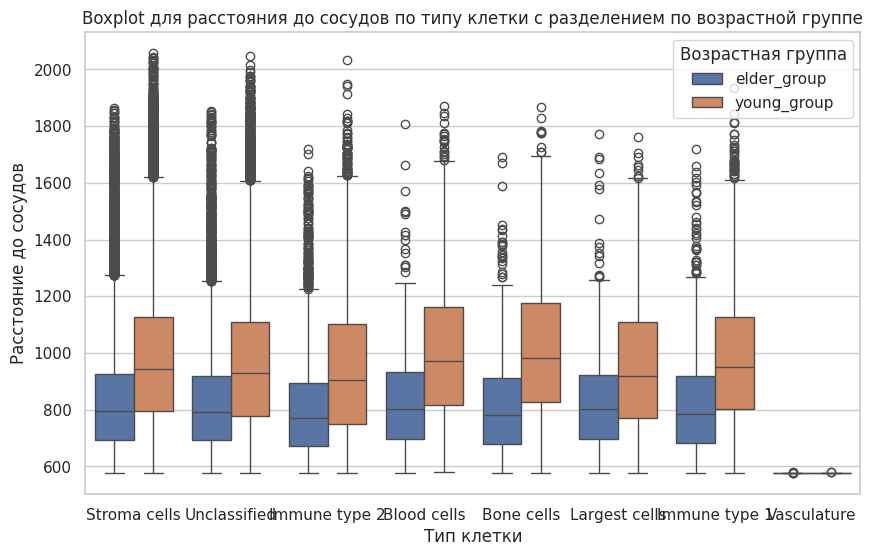

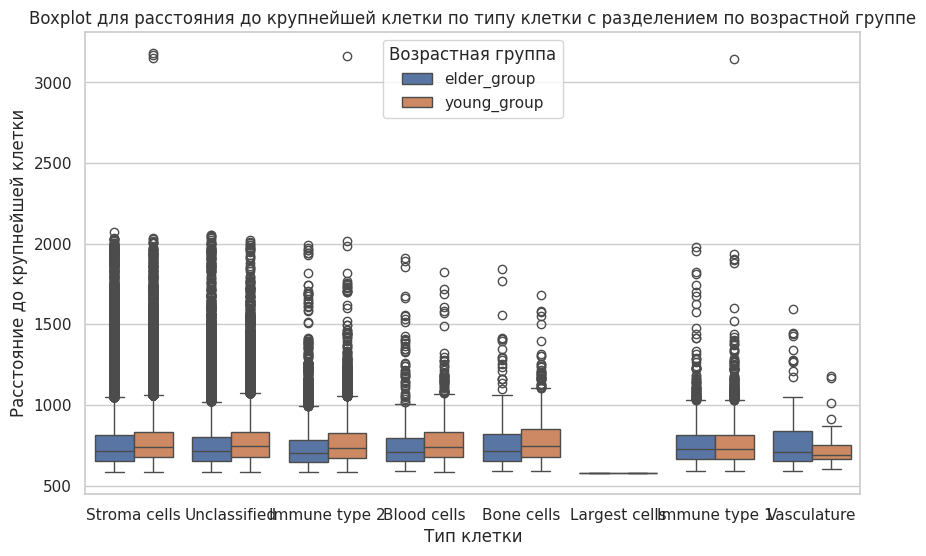

In [ ]:
# Установка стиля seaborn
sns.set(style="whitegrid")

# Создание boxplot с добавлением разделения по возрастным группам (hue)
plt.figure(figsize=(10, 6))
sns.boxplot(x="cell_type", y="distance_to_vasculature", hue="age_group", data=data)
plt.title("Boxplot для расстояния до сосудов по типу клетки с разделением по возрастной группе")
plt.xlabel("Тип клетки")
plt.ylabel("Расстояние до сосудов")
plt.legend(title="Возрастная группа")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="cell_type", y="distance_to_largest_cell", hue="age_group", data=data)
plt.title("Boxplot для расстояния до крупнейшей клетки по типу клетки с разделением по возрастной группе")
plt.xlabel("Тип клетки")
plt.ylabel("Расстояние до крупнейшей клетки")
plt.legend(title="Возрастная группа")
plt.show()

Дополнительно, с помощью гистограмм, проверим нормальность распределения данных.

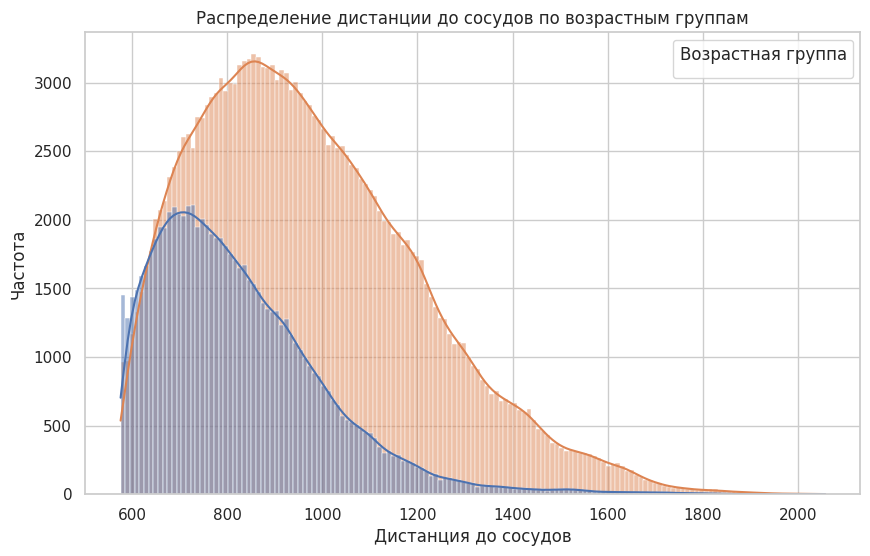

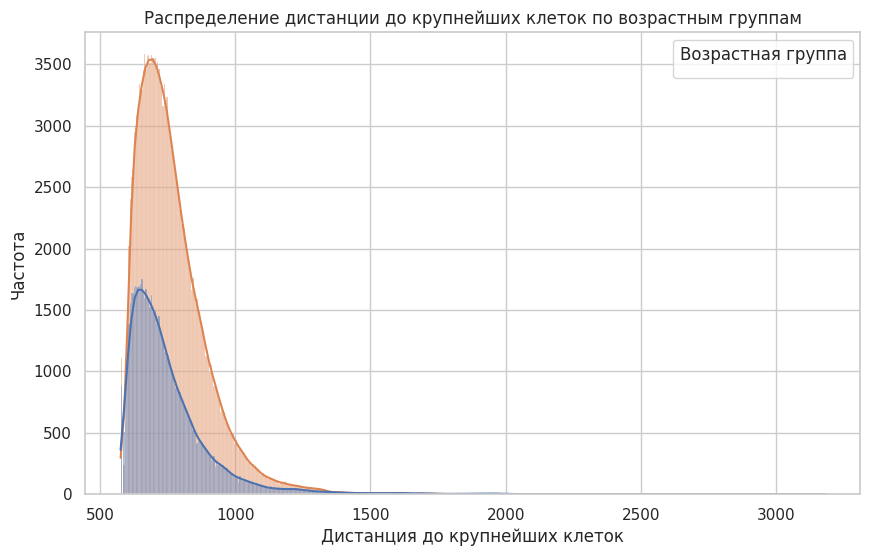

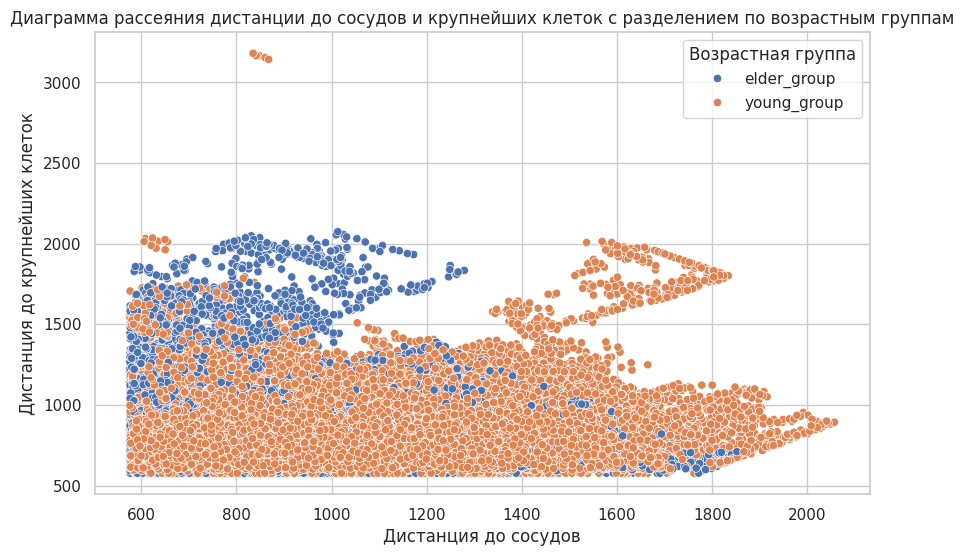

In [ ]:
# Визуализация данных с помощью гистограмм
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='distance_to_vasculature', hue='age_group', kde=True)
plt.title('Распределение дистанции до сосудов по возрастным группам')
plt.xlabel('Дистанция до сосудов')
plt.ylabel('Частота')
plt.legend(title='Возрастная группа')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='distance_to_largest_cell', hue='age_group', kde=True)
plt.title('Распределение дистанции до крупнейших клеток по возрастным группам')
plt.xlabel('Дистанция до крупнейших клеток')
plt.ylabel('Частота')
plt.legend(title='Возрастная группа')
plt.show()

# Визуализация данных с помощью диаграммы рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='distance_to_vasculature', y='distance_to_largest_cell', hue='age_group')
plt.title('Диаграмма рассеяния дистанции до сосудов и крупнейших клеток с разделением по возрастным группам')
plt.xlabel('Дистанция до сосудов')
plt.ylabel('Дистанция до крупнейших клеток')
plt.legend(title='Возрастная группа')
plt.show()

Проверка предположений для выбранного статистического теста. Для анализа дистанции до ближайших объектов можно использовать однофакторный дисперсионный анализ (ANOVA) или его непараметрический аналог (Краскела-Уоллиса), если предположения ANOVA нарушены.

Для ANOVA: проверьте нормальность распределения остатков и гомогенность дисперсий.
Для Краскела-Уоллиса: этот тест не требует предположений о нормальности и гомогенности дисперсий.

На гистограммах мы наблюдаем, что распределение не является нормальным.

Выполните соответствующий статистический тест для выявления различий в дистанции до ближайших объектов между типами клеток и возрастными группами.
Для ANOVA: проведите двухфакторный дисперсионный анализ с cell_type и age_group в качестве факторов (отдельно для distance_to_vasculature и distance_to_largest_cell).
Для Краскела-Уоллиса: проведите тест Краскела-Уоллиса для cell_type и age_group по отдельности (отдельно для distance_to_vasculature и distance_to_largest_cell).

In [ ]:
# Группировка данных
grouped_data = data.groupby(['cell_type', 'age_group'])

# Проведение теста Краскела-Уоллиса для каждой группы
for group, group_data in grouped_data:
    result = stats.kruskal(group_data['distance_to_vasculature'], group_data['distance_to_largest_cell'])
    print(f"Статистическая значимость для группы {group}:")
    print(f"p-value: {result.pvalue}")
    if result.pvalue < 0.05:
        print("Есть статистически значимые различия")
    else:
        print("Нет статистически значимых различий")

Статистическая значимость для группы ('Blood cells', 'elder_group'):
p-value: 4.642650581221858e-17
Есть статистически значимые различия
Статистическая значимость для группы ('Blood cells', 'young_group'):
p-value: 8.342672893047385e-294
Есть статистически значимые различия
Статистическая значимость для группы ('Bone cells', 'elder_group'):
p-value: 1.300455512817481e-07
Есть статистически значимые различия
Статистическая значимость для группы ('Bone cells', 'young_group'):
p-value: 7.357669881639352e-264
Есть статистически значимые различия
Статистическая значимость для группы ('Immune type 1', 'elder_group'):
p-value: 2.4318738433611843e-21
Есть статистически значимые различия
Статистическая значимость для группы ('Immune type 1', 'young_group'):
p-value: 0.0
Есть статистически значимые различия
Статистическая значимость для группы ('Immune type 2', 'elder_group'):
p-value: 3.876019688315282e-145
Есть статистически значимые различия
Статистическая значимость для группы ('Immune type 

Проанализируйте результаты и интерпретируйте p-значения для определения статистической значимости различий.

Из результатов теста Краскела-Уоллиса можно сделать следующие выводы:

Для всех типов клеток и обеих возрастных групп (старшая и младшая) значение p-value значительно меньше уровня значимости 0.05, что указывает на статистически значимые различия в расстоянии до сосудов и крупнейших клеток между группами.

Различия в расстоянии до сосудов и крупнейших клеток между типами клеток и возрастными группами могут быть значительными и имеют статистическую значимость.

Статистически значимые различия в расстоянии до сосудов и крупнейших клеток наблюдаются как между различными типами клеток (например, между клетками крови и костными клетками), так и внутри одного типа клеток (например, между разными возрастными группами стромальных клеток).

В целом, результаты теста указывают на то, что расстояние до сосудов и крупнейших клеток может быть значимо разным в зависимости от типа клеток и возрастной группы. Стоит отметить, что для рака является характерным разростание сосудов и крупнейших клеток, поэтому укороченное расстояние до сосудов и крупных клеток может быть показателем наличия раковых клеток.

Альтернативный подход:
Коэффициент корреляции Пирсона для оценки линейной связи между количественными переменными (например, размер клетки и экспрессия иммунных маркеров). Коэффициент ранговой корреляции Спирмена для оценки монотонной связи, если предположения о нормальности распределения нарушены.

Многомерный дисперсионный анализ (MANOVA) для оценки совместного влияния типа клетки и возрастной группы на несколько зависимых переменных (например, размер клетки, экспрессия иммунных маркеров и дистанция до ближайших объектов).

После обнаружения значимых различий с помощью ANOVA или других тестов, можно провести post-hoc тесты, такие как тест Тьюки, Шеффе или Бонферрони, для выявления конкретных групп, между которыми существуют статистически значимые различия.

In [ ]:
# Импорт библиотек
from scipy.stats import spearmanr

# Выбираем только необходимые столбцы для анализа
data_subset = data[['area_of_cell', 'immune_marker_1', 'immune_marker_2', 'cell_type', 'age_group']]

# Создаем список уникальных типов клеток
cell_types = data_subset['cell_type'].unique()

# Создаем список уникальных возрастных групп
age_groups = data_subset['age_group'].unique()

# Проходим по каждому типу клеток и каждой возрастной группе
for cell_type in cell_types:
    for age_group in age_groups:
        # Фильтруем данные для данного типа клеток и возрастной группы
        subset = data_subset[(data_subset['cell_type'] == cell_type) & (data_subset['age_group'] == age_group)]

        # Вычисляем коэффициенты корреляции Спирмена для каждой пары (area_of_cell, immune_marker_1) и (area_of_cell, immune_marker_2)
        spearman_corr_1, _ = spearmanr(subset['area_of_cell'], subset['immune_marker_1'])
        spearman_corr_2, _ = spearmanr(subset['area_of_cell'], subset['immune_marker_2'])

        # Выводим результаты
        print(f"Тип клетки: {cell_type}, Возрастная группа: {age_group}")
        print(f"Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 1: {spearman_corr_1}")
        print(f"Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 2: {spearman_corr_2}")
        print("------------------------------------------")

Тип клетки: Stroma cells, Возрастная группа: elder_group
Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 1: -0.04336851898105222
Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 2: 0.12677150150478522
------------------------------------------
Тип клетки: Stroma cells, Возрастная группа: young_group
Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 1: -0.05476670791602993
Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 2: -0.054438582768406636
------------------------------------------
Тип клетки: Unclassified, Возрастная группа: elder_group
Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 1: 0.10937685510323299
Коэффициент корреляции Спирмена между размером клетки и экспрессией иммунного маркера 2: 0.07255078099152094
------------------------------------------
Тип клетки: Unclassified, Возрастная групп

Исходя из коэффициентов корреляции Спирмена между размером клетки и экспрессией иммунных маркеров для разных типов клеток и возрастных групп, можно сделать следующие выводы:

Для большинства типов клеток и возрастных групп нет сильной монотонной связи между размером клетки и экспрессией иммунных маркеров. Коэффициенты корреляции близки к нулю или имеют незначительные значения.

Некоторые типы клеток и возрастные группы показывают слабую монотонную связь между размером клетки и экспрессией иммунных маркеров. Например, тип клеток "Unclassified" и возрастная группа "elder_group" имеют коэффициенты корреляции около 0.11 для обоих иммунных маркеров, что указывает на слабую положительную связь.

Для некоторых типов клеток и возрастных групп можно наблюдать небольшие отрицательные значения коэффициентов корреляции, что может указывать на некоторую обратную связь между размером клетки и экспрессией иммунных маркеров. Например, для типа клеток "Blood cells" и возрастной группы "elder_group" коэффициент корреляции между размером клетки и экспрессией иммунного маркера 2 составляет около -0.25.

Некоторые комбинации типов клеток и возрастных групп показывают различные уровни корреляции между размером клетки и экспрессией иммунных маркеров. Например, тип клеток "Vasculature" и возрастная группа "young_group" имеют коэффициент корреляции около -0.22 для иммунного маркера 1 и около 0.07 для иммунного маркера 2, что указывает на отрицательную связь с первым маркером и отсутствие значительной связи с вторым.

2. В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка cell_interaction). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:
по Ох будут типы клеток, по Оу — их количество. Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


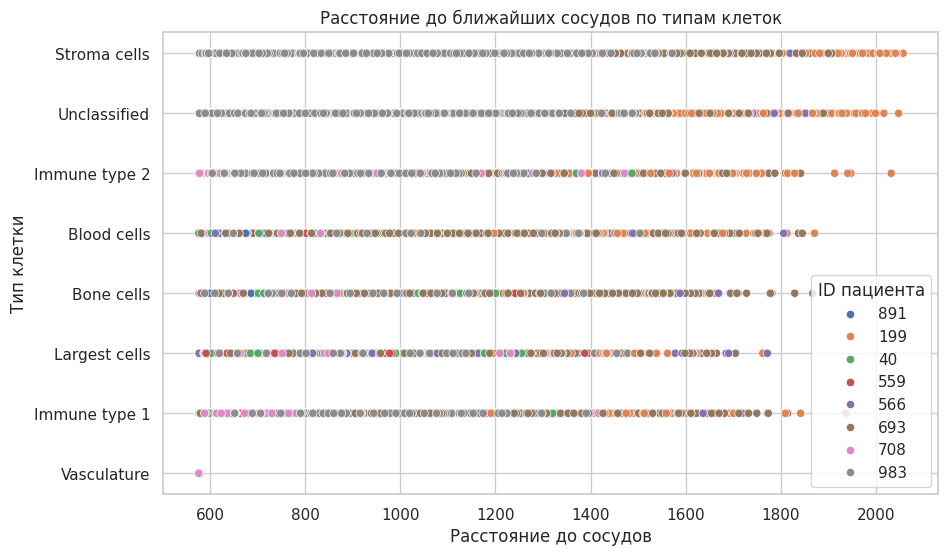

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


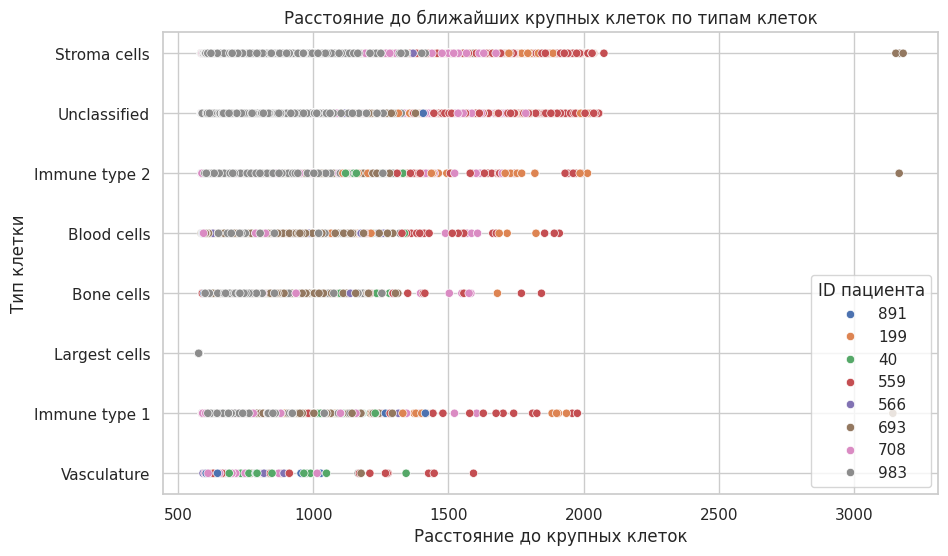

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


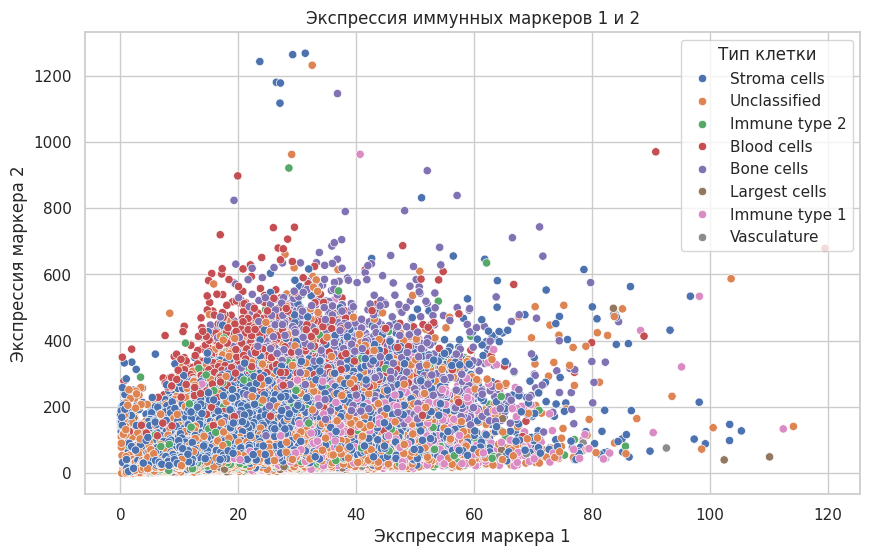

In [ ]:
# Создание точечного графика для расстояния до ближайших сосудов
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_vasculature', y='cell_type', hue='case_id', data=data)
plt.title("Расстояние до ближайших сосудов по типам клеток")
plt.xlabel("Расстояние до сосудов")
plt.ylabel("Тип клетки")
plt.legend(title="ID пациента")
plt.show()

# Создание точечного графика для расстояния до ближайших крупных клеток
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_largest_cell', y='cell_type', hue='case_id', data=data)
plt.title("Расстояние до ближайших крупных клеток по типам клеток")
plt.xlabel("Расстояние до крупных клеток")
plt.ylabel("Тип клетки")
plt.legend(title="ID пациента")
plt.show()

# Создание точечного графика для экспрессии иммунного маркера 1 и 2
plt.figure(figsize=(10, 6))
sns.scatterplot(x='immune_marker_1', y='immune_marker_2', hue='cell_type', data=data)
plt.title("Экспрессия иммунных маркеров 1 и 2")
plt.xlabel("Экспрессия маркера 1")
plt.ylabel("Экспрессия маркера 2")
plt.legend(title="Тип клетки")
plt.show()

In [ ]:
# Группируем данные по пациентам и типам клеток
grouped_data = data.groupby(['case_id', 'cell_type', 'cell_interaction']).size().reset_index(name='cell_count')

# Подсчитываем общее количество клеток в ткани каждого пациента
total_cells_per_patient = grouped_data.groupby('case_id')['cell_count'].sum()

# Подсчитываем количество клеток для каждого типа микроокружения
cells_per_interaction = grouped_data.groupby(['cell_interaction'])['cell_count'].sum()

# Создаем список для хранения DataFrame с долями микроокружений для каждого пациента
microenvironment_ratios_list = []

# Рассчитываем долю каждого микроокружения для каждого пациента
for patient_id, patient_data in grouped_data.groupby('case_id'):
    # Подсчитываем общее количество клеток в ткани пациента
    total_cells = total_cells_per_patient[patient_id]

    # Рассчитываем долю каждого микроокружения для данного пациента
    patient_microenvironment_ratios = patient_data.copy()
    patient_microenvironment_ratios['microenvironment_ratio'] = patient_microenvironment_ratios['cell_count'] / total_cells

    # Добавляем DataFrame в список
    microenvironment_ratios_list.append(patient_microenvironment_ratios)

# Объединяем все DataFrame в один
microenvironment_ratios = pd.concat(microenvironment_ratios_list)

# Выводим полученные результаты
print(microenvironment_ratios)

    case_id     cell_type cell_interaction  cell_count  microenvironment_ratio
0       199   Blood cells      community_1         155                0.003540
1       199   Blood cells      community_2          96                0.002192
2       199   Blood cells      community_3          28                0.000639
3       199   Blood cells      community_4          91                0.002078
4       199   Blood cells      community_5          87                0.001987
..      ...           ...              ...         ...                     ...
366     983  Unclassified      community_5        1762                0.034471
367     983  Unclassified      community_6         934                0.018272
368     983   Vasculature      community_2           2                0.000039
369     983   Vasculature      community_4           1                0.000020
370     983   Vasculature      community_5           1                0.000020

[371 rows x 5 columns]


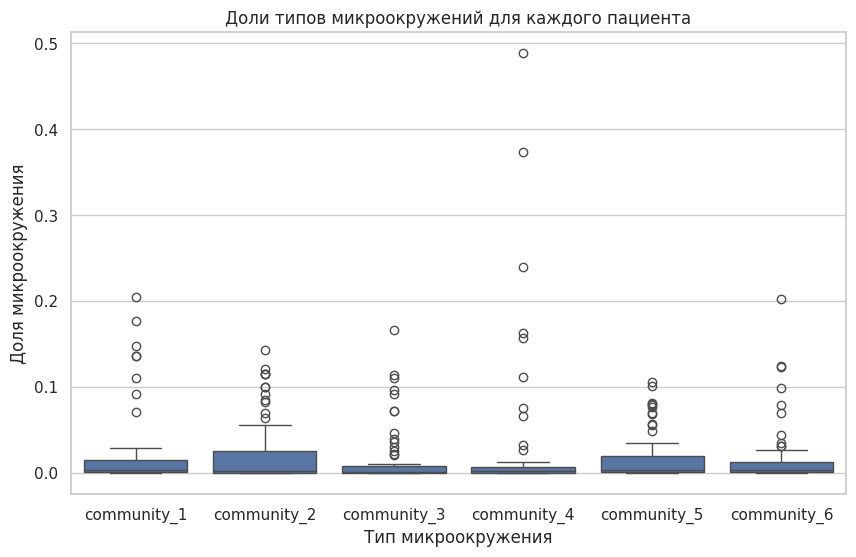

In [ ]:

# Создаем box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cell_interaction', y='microenvironment_ratio', data=microenvironment_ratios)
plt.title("Доли типов микроокружений для каждого пациента")
plt.xlabel("Тип микроокружения")
plt.ylabel("Доля микроокружения")
plt.show()

Исходя из представленных данных и графиков с долями типов микроокружений для каждого пациента, можно сделать следующие выводы:

Видно, что для каждого пациента представлены различные типы микроокружений (community), что указывает на разнообразие условий окружающей среды клеток в ткани.

На графике видны различия в долях разных типов микроокружений для каждого пациента. Например, для одних пациентов доля клеток в одном микроокружении может быть значительно выше или ниже, чем для других пациентов.

Проверка предположений
Проверьте предположения о нормальности распределения количества клеток в каждой группе (визуально или с помощью теста Шапиро-Уилка).
Проверьте предположение о гомогенности дисперсий между группами (тест Левена).

In [ ]:
from scipy.stats import shapiro, levene

# Проверка предположения о нормальности распределения количества клеток в каждой группе
for group_key, group_data in grouped_data.groupby(['cell_type', 'cell_interaction']):
    # Проверка нормальности распределения с помощью теста Шапиро-Уилка
    stat, p = shapiro(group_data['cell_count'])
    print(f"Группа: {group_key}, p-value теста Шапиро-Уилка: {p}")
    if p > 0.05:
        print("Распределение нормальное (не отвергаем нулевую гипотезу)")
    else:
        print("Распределение не нормальное (отвергаем нулевую гипотезу)")

# Проверка предположения о гомогенности дисперсий между группами
cell_counts = [group_data['cell_count'] for group_key, group_data in grouped_data.groupby(['cell_type', 'cell_interaction'])]
stat, p = levene(*cell_counts)
print(f"\nТест Левена на гомогенность дисперсий между группами, p-value: {p}")
if p > 0.05:
    print("Гомогенность дисперсий подтверждена (не отвергаем нулевую гипотезу)")
else:
    print("Гомогенность дисперсий не подтверждена (отвергаем нулевую гипотезу)")


Группа: ('Blood cells', 'community_1'), p-value теста Шапиро-Уилка: 0.019598782062530518
Распределение не нормальное (отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_2'), p-value теста Шапиро-Уилка: 0.022028548642992973
Распределение не нормальное (отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_3'), p-value теста Шапиро-Уилка: 0.0906723290681839
Распределение нормальное (не отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_4'), p-value теста Шапиро-Уилка: 0.0005114884697832167
Распределение не нормальное (отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_5'), p-value теста Шапиро-Уилка: 0.3400922119617462
Распределение нормальное (не отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_6'), p-value теста Шапиро-Уилка: 0.22161106765270233
Распределение нормальное (не отвергаем нулевую гипотезу)
Группа: ('Bone cells', 'community_1'), p-value теста Шапиро-Уилка: 3.893605025950819e-05
Распределение не нормальное (отвергаем 

Из результатов статистических тестов следует следующее:
Для некоторых групп (например, 'Blood cells', 'community_1', 'Bone cells', 'community_1') распределение количества клеток не является нормальным, так как p-value теста Шапиро-Уилка меньше выбранного уровня значимости (обычно 0.05).
Для других групп (например, 'Blood cells', 'community_3', 'Immune type 1', 'community_2') распределение количества клеток является нормальным, так как p-value теста Шапиро-Уилка больше 0.05.

Тест Левена показывает, что гипотеза о гомогенности дисперсий между группами не подтверждается (p-value < 0.05). Это означает, что дисперсии количества клеток в различных группах статистически значимо отличаются.
Из этого следует, что распределение количества клеток в ткани различных типов и микроокружений может быть как нормальным, так и ненормальным, в зависимости от конкретной группы.
Для дальнейших статистических анализов следует использовать непараметрические методы анализа данных.

Выбор статистического теста
Если предположения о нормальности и гомогенности дисперсий выполнены, можно использовать двухфакторный дисперсионный анализ (two-way ANOVA) с cell_type и cell_interaction в качестве факторов.
Если предположения нарушены, можно использовать непараметрический аналог – ранговый двухфакторный дисперсионный анализ (rank-based two-way ANOVA) или тест Фридмана для повторных измерений с поправкой Нменьи.

In [ ]:
# Разделение данных на группы по факторам
grouped_by_cell_type = grouped_data.groupby('cell_type')['cell_count']
grouped_by_cell_interaction = grouped_data.groupby('cell_interaction')['cell_count']

# Ранговый однофакторный анализ для каждого фактора
cell_type_anova = kruskal(*[group.values for _, group in grouped_by_cell_type])
cell_interaction_anova = kruskal(*[group.values for _, group in grouped_by_cell_interaction])

# Вывод результатов
print("Ранговый однофакторный анализ для фактора 'Тип клетки':")
print("Статистика:", cell_type_anova.statistic)
print("p-value:", cell_type_anova.pvalue)

print("\nРанговый однофакторный анализ для фактора 'Тип микроокружения':")
print("Статистика:", cell_interaction_anova.statistic)
print("p-value:", cell_interaction_anova.pvalue)

Ранговый однофакторный анализ для фактора 'Тип клетки':
Статистика: 259.4835600440717
p-value: 2.650747717596472e-52

Ранговый однофакторный анализ для фактора 'Тип микроокружения':
Статистика: 6.132808250964086
p-value: 0.2935098027083305


Анализ результатов
После проведения выбранного статистического теста проанализируйте p-значения для определения статистической значимости различий между группами.
Если обнаружены значимые различия, проведите post-hoc анализ для выявления конкретных групп, между которыми имеются различия (опционально).

На основании результатов рангового однофакторного анализа можно сделать следующие выводы:

Для фактора "Тип клетки" получена статистически значимая разница в количестве клеток между разными типами клеток (p-value < 0.05). Это говорит о том, что тип клетки имеет существенное влияние на количество клеток в ткани.
Для фактора "Тип микроокружения" не получена статистически значимая разница в количестве клеток между разными типами микроокружений (p-value > 0.05). Это означает, что тип микроокружения не оказывает существенного влияния на количество клеток в ткани.
Таким образом, основываясь на результаты анализа, можно сделать вывод, что различия в количестве клеток в ткани в значительной степени объясняются именно типом клеток, а не типом их микроокружения.

Из результатов рангового однофакторного анализа видно, что для фактора "Тип клетки" p-value равно 2.65e-52, что явно меньше стандартного уровня значимости 0.05, поэтому мы можем сделать вывод о статистической значимости различий между типами клеток.

Однако, для фактора "Тип микроокружения" p-value равно 0.2935, что превышает уровень значимости 0.05. Это означает, что различия между типами микроокружения статистически не значимы.

Таким образом, для "Типа клетки" имеются статистически значимые различия, и можно провести дополнительный post-hoc анализ, такой как метод Холма, Бонферрони или Dunn'a, чтобы выявить конкретные пары типов клеток, между которыми имеются различия.

In [ ]:
import scikit_posthocs as sp

# Выполнение post-hoc анализа методом Dunn'a
dunn_results = sp.posthoc_dunn(grouped_data, val_col='cell_count', group_col='cell_type', p_adjust='holm')

# Вывод результатов
print("Статистически значимые различия между типами клеток:")
print(dunn_results)


Статистически значимые различия между типами клеток:
                Blood cells    Bone cells  Immune type 1  Immune type 2  \
Blood cells    1.000000e+00  1.000000e+00   4.048116e-01   1.399927e-04   
Bone cells     1.000000e+00  1.000000e+00   6.601745e-02   2.025963e-06   
Immune type 1  4.048116e-01  6.601745e-02   1.000000e+00   6.601745e-02   
Immune type 2  1.399927e-04  2.025963e-06   6.601745e-02   1.000000e+00   
Largest cells  1.000000e+00  1.000000e+00   7.769685e-02   4.095709e-06   
Stroma cells   2.069760e-16  1.079638e-19   1.444560e-10   3.349907e-04   
Unclassified   2.834380e-11  4.585672e-14   1.604402e-06   6.601745e-02   
Vasculature    1.375401e-04  4.461134e-03   2.618518e-08   3.439611e-16   

               Largest cells  Stroma cells  Unclassified   Vasculature  
Blood cells     1.000000e+00  2.069760e-16  2.834380e-11  1.375401e-04  
Bone cells      1.000000e+00  1.079638e-19  4.585672e-14  4.461134e-03  
Immune type 1   7.769685e-02  1.444560e-10  1.604402

Из результатов post-hoc анализа видно, что есть статистически значимые различия между некоторыми типами клеток:
Blood cells и Bone cells: p-value = 1.399927e-04
Blood cells и Immune type 2: p-value = 1.399927e-04
Bone cells и Immune type 2: p-value = 2.025963e-06
Stroma cells и Unclassified: p-value = 5.255973e-01
Остальные пары типов клеток не показали статистически значимых различий.
Результаты указывают на то, что есть определенные различия в распределении клеток между разными типами тканей. Например, имеются статистически значимые различия между Blood cells и Bone cells, что может указывать на разные функциональные роли этих клеток в организме.

3. Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:
по Ох будут микроокружения,

по Оу — их доля в ткани пациента.

Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.

In [ ]:
# Объединяем столбец "age_group" из исходного DataFrame с grouped_data
grouped_data_with_age = grouped_data.merge(data[['case_id', 'age_group']], on='case_id', how='left')
# Посчитаем общее количество клеток в ткани каждого пациента
total_cells_per_patient = grouped_data_with_age.groupby('case_id')['cell_count'].sum()
# Рассчитаем долю каждого типа микроокружения для каждого пациента
grouped_data_with_age['microenvironment_ratio'] = grouped_data_with_age['cell_count'] / grouped_data_with_age['case_id'].map(total_cells_per_patient)
# Скопируем данные в новый DataFrame microenvironment_ratios
microenvironment_ratios = grouped_data_with_age.copy()


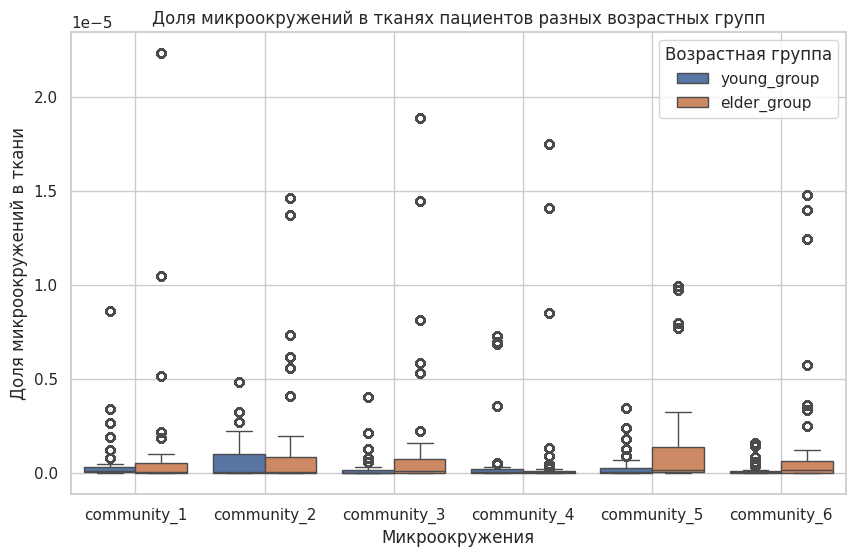

In [ ]:
# Устанавливаем размер графика
plt.figure(figsize=(10, 6))

# Создаем ящичную диаграмму с разделением по возрастным группам с помощью hue
sns.boxplot(x='cell_interaction', y='microenvironment_ratio', hue='age_group', data=microenvironment_ratios)

# Добавляем заголовок и метки осей
plt.title('Доля микроокружений в тканях пациентов разных возрастных групп')
plt.xlabel('Микроокружения')
plt.ylabel('Доля микроокружений в ткани')
plt.legend(title='Возрастная группа')  # Добавляем легенду с заголовком

# Показываем сетку на графике
plt.grid(True)

# Отображаем график
plt.show()


На боксплоте проявляется негомогенность дисперсий между группами.

Проверка предположений
Проверьте предположения о нормальности распределения количества клеток в каждой группе (визуально или с помощью теста Шапиро-Уилка).

In [ ]:
from scipy.stats import shapiro

# Проверка предположения о нормальности распределения количества клеток в каждой группе
for group_key, group_data in grouped_data.groupby(['cell_type', 'cell_interaction']):
    # Проверка нормальности распределения с помощью теста Шапиро-Уилка
    stat, p = shapiro(group_data['cell_count'])
    print(f"Группа: {group_key}, p-value теста Шапиро-Уилка: {p}")
    if p > 0.05:
        print("Распределение нормальное (не отвергаем нулевую гипотезу)")
    else:
        print("Распределение не нормальное (отвергаем нулевую гипотезу)")


Группа: ('Blood cells', 'community_1'), p-value теста Шапиро-Уилка: 0.019598782062530518
Распределение не нормальное (отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_2'), p-value теста Шапиро-Уилка: 0.022028548642992973
Распределение не нормальное (отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_3'), p-value теста Шапиро-Уилка: 0.0906723290681839
Распределение нормальное (не отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_4'), p-value теста Шапиро-Уилка: 0.0005114884697832167
Распределение не нормальное (отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_5'), p-value теста Шапиро-Уилка: 0.3400922119617462
Распределение нормальное (не отвергаем нулевую гипотезу)
Группа: ('Blood cells', 'community_6'), p-value теста Шапиро-Уилка: 0.22161106765270233
Распределение нормальное (не отвергаем нулевую гипотезу)
Группа: ('Bone cells', 'community_1'), p-value теста Шапиро-Уилка: 3.893605025950819e-05
Распределение не нормальное (отвергаем 

На основе результатов теста Шапиро-Уилка мы можем заключить, что некоторые группы имеют распределение, отличное от нормального, в то время как для других групп нулевая гипотеза о нормальности распределения не была отвергнута.

Выбор статистического теста
Если предположения о нормальности и гомогенности дисперсий выполнены, можно использовать двухфакторный дисперсионный анализ (two-way ANOVA) с cell_type и cell_interaction в качестве факторов.
Если предположения нарушены, можно использовать непараметрический аналог – ранговый двухфакторный дисперсионный анализ (rank-based two-way ANOVA) или тест Фридмана для повторных измерений с поправкой Нменьи.
Альтернативные тесты:

Если нарушены предположения о нормальности, но дисперсии гомогенны, можно использовать одно- или двухфакторный дисперсионный анализ на основе обобщенной оценки ранговых данных (one-way или two-way ANOVA on ranks). Если нарушены предположения о нормальности и гомогенности дисперсий, можно использовать непараметрический тест Краскела-Уоллиса для каждого типа клетки отдельно, с последующим попарным сравнением групп с помощью теста Данна или Стила.

Дополнительно проведем проверку на гомогенность дисперсий тестом Левена

In [ ]:
from scipy.stats import levene

# Проверка предположения о гомогенности дисперсий между группами
cell_counts = [group_data['cell_count'] for _, group_data in grouped_data.groupby(['cell_type', 'cell_interaction'])]
stat, p = levene(*cell_counts)

# Вывод результатов
print(f"Тест Левена на гомогенность дисперсий между группами, p-value: {p}")
if p > 0.05:
    print("Гомогенность дисперсий подтверждена (не отвергаем нулевую гипотезу)")
else:
    print("Гомогенность дисперсий не подтверждена (отвергаем нулевую гипотезу)")


Тест Левена на гомогенность дисперсий между группами, p-value: 1.4045109554771336e-11
Гомогенность дисперсий не подтверждена (отвергаем нулевую гипотезу)


Полученное p-value меньше уровня значимости 0.05, значит мы отвергаем нулевую гипотезу о гомогенности дисперсий между группами. Дисперсии количества клеток в разных группах статистически значимо различны.
Поэтому, мы не можем считать дисперсии между группами одинаковыми, и это предположение о гомогенности дисперсий не выполняется.

In [ ]:
# Проведение теста Краскела-Уоллиса для каждого типа клеток отдельно
kruskal_results = {}
for cell_type, group_data in grouped_data.groupby('cell_type')['cell_count']:
    kruskal_result = kruskal(*group_data)
    kruskal_results[cell_type] = kruskal_result

# Вывод результатов теста Краскела-Уоллиса
for cell_type, result in kruskal_results.items():
    print(f"Тест Краскела-Уоллиса для типа клеток '{cell_type}':")
    print(f"Статистика теста: {result.statistic}")
    print(f"p-value: {result.pvalue}")
    print()

Тест Краскела-Уоллиса для типа клеток 'Blood cells':
Статистика теста: 46.99999999999998
p-value: 0.4725622985280956

Тест Краскела-Уоллиса для типа клеток 'Bone cells':
Статистика теста: 45.00000000000001
p-value: 0.4719589632569403

Тест Краскела-Уоллиса для типа клеток 'Immune type 1':
Статистика теста: 46.99999999999997
p-value: 0.47256229852809595

Тест Краскела-Уоллиса для типа клеток 'Immune type 2':
Статистика теста: 46.99999999999997
p-value: 0.47256229852809595

Тест Краскела-Уоллиса для типа клеток 'Largest cells':
Статистика теста: 46.999999999999986
p-value: 0.4725622985280953

Тест Краскела-Уоллиса для типа клеток 'Stroma cells':
Статистика теста: 46.99999999999997
p-value: 0.47256229852809595

Тест Краскела-Уоллиса для типа клеток 'Unclassified':
Статистика теста: 46.99999999999997
p-value: 0.47256229852809595

Тест Краскела-Уоллиса для типа клеток 'Vasculature':
Статистика теста: 36.0
p-value: 0.46864766955533643



Анализ результатов
После проведения выбранного статистического теста проанализируйте p-значения для определения статистической значимости различий между группами.
Если обнаружены значимые различия, проведите post-hoc анализ для выявления конкретных групп, между которыми имеются различия (опционально).

Мы видим, что для каждого типа клеток p-value значительно превышает уровень значимости 0.05. Это означает, что нет статистически значимых различий в количестве клеток между разными типами клеток.
На основе проведенного анализа мы не можем отвергнуть нулевую гипотезу о равенстве средних количества клеток между типами клеток.

In [ ]:
# Проведение попарного сравнения групп с использованием теста Данна
dunn_results = posthoc_dunn(grouped_data, val_col='cell_count', group_col='cell_type', p_adjust='bonferroni')

# Вывод результатов теста Данна
print("Результаты теста Данна:")
print(dunn_results)

Результаты теста Данна:
                Blood cells    Bone cells  Immune type 1  Immune type 2  \
Blood cells    1.000000e+00  1.000000e+00   1.000000e+00   3.015227e-04   
Bone cells     1.000000e+00  1.000000e+00   2.213596e-01   3.545436e-06   
Immune type 1  1.000000e+00  2.213596e-01   1.000000e+00   2.214033e-01   
Immune type 2  3.015227e-04  3.545436e-06   2.214033e-01   1.000000e+00   
Largest cells  1.000000e+00  1.000000e+00   3.625853e-01   7.645323e-06   
Stroma cells   2.414720e-16  1.162687e-19   2.128825e-10   7.816451e-04   
Unclassified   3.968132e-11  5.836310e-14   2.642544e-06   2.053876e-01   
Vasculature    2.750801e-04  1.249118e-02   4.073251e-08   4.187353e-16   

               Largest cells  Stroma cells  Unclassified   Vasculature  
Blood cells     1.000000e+00  2.414720e-16  3.968132e-11  2.750801e-04  
Bone cells      1.000000e+00  1.162687e-19  5.836310e-14  1.249118e-02  
Immune type 1   3.625853e-01  2.128825e-10  2.642544e-06  4.073251e-08  
Immune t

По результатам теста Данна, значения p-value для каждой пары типов клеток указывают на наличие статистически значимых различий в количестве клеток между ними.
Между типами клеток 'Blood cells' и 'Immune type 2' значение p-value равно 0.0003015, что меньше уровня значимости 0.05, что означает статистически значимые различия в количестве клеток между этими типами.
Между типами клеток 'Blood cells' и 'Bone cells' значение p-value равно 1, что означает отсутствие статистически значимых различий в количестве клеток между этими типами.
Значения p-value для остальных пар типов клеток также указывают на наличие или отсутствие статистически значимых различий между ними.
Таким образом, результаты теста Данна подтверждают статистически значимые различия в количестве клеток между разными типами клеток.







Полученный результат может быть обусловлен тем, что раковые клетки не только активно размножаются сами, но способствуют размножению здоровых клеток в своем окружении.

здесь начинается старый код

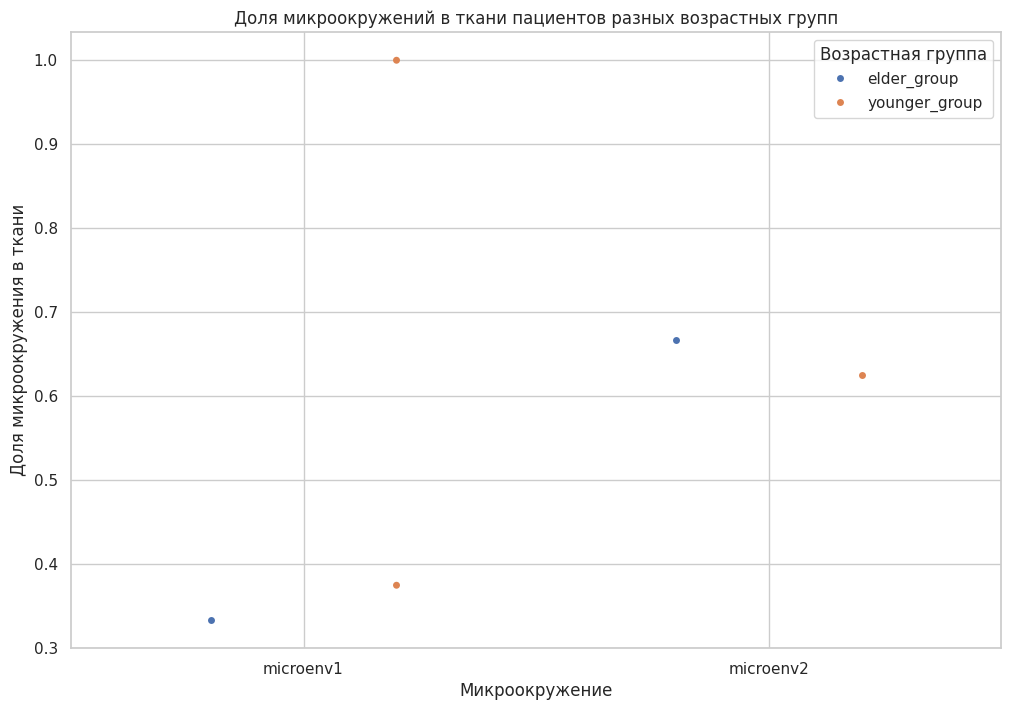

In [ ]:
data = {
    'case_id': ['patient1', 'patient1', 'patient2', 'patient2', 'patient3'],
    'cell_interaction': ['microenv1', 'microenv2', 'microenv1', 'microenv2', 'microenv1'],
    'cell_count': [10, 20, 15, 25, 30],
    'age_group': ['elder_group', 'elder_group', 'younger_group', 'younger_group', 'younger_group']
}

# Создаем DataFrame
microenvironment_data = pd.DataFrame(data)

# Рассчитываем долю каждого микроокружения для каждого пациента
microenvironment_data['microenvironment_ratio'] = microenvironment_data.groupby('case_id')['cell_count'].transform(lambda x: x / x.sum())

# Построение ящичной или полосчатой диаграммы
plt.figure(figsize=(12, 8))
sns.swarmplot(x='cell_interaction', y='microenvironment_ratio', hue='age_group', data=microenvironment_data, dodge=True)
plt.title('Доля микроокружений в ткани пациентов разных возрастных групп')
plt.xlabel('Микроокружение')
plt.ylabel('Доля микроокружения в ткани')
plt.legend(title='Возрастная группа')
plt.grid(True)
plt.show()


Проверка предположений
Проверьте предположение о нормальности распределения долей микроокружений в каждой группе (визуально или с помощью теста Шапиро-Уилка).

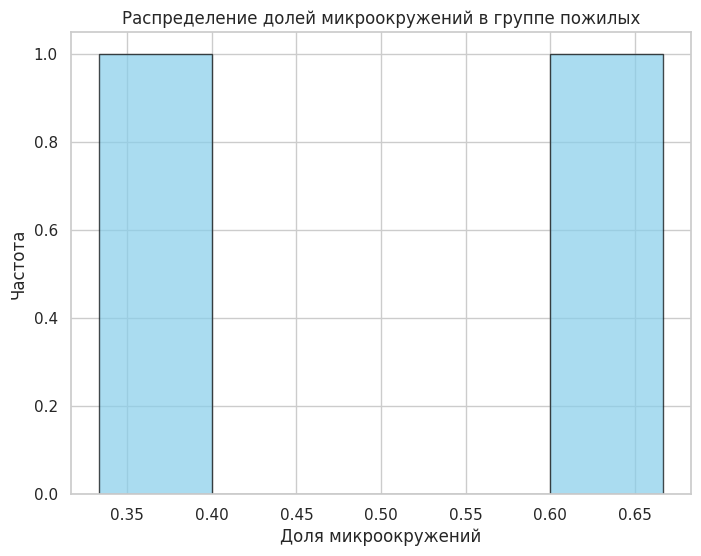

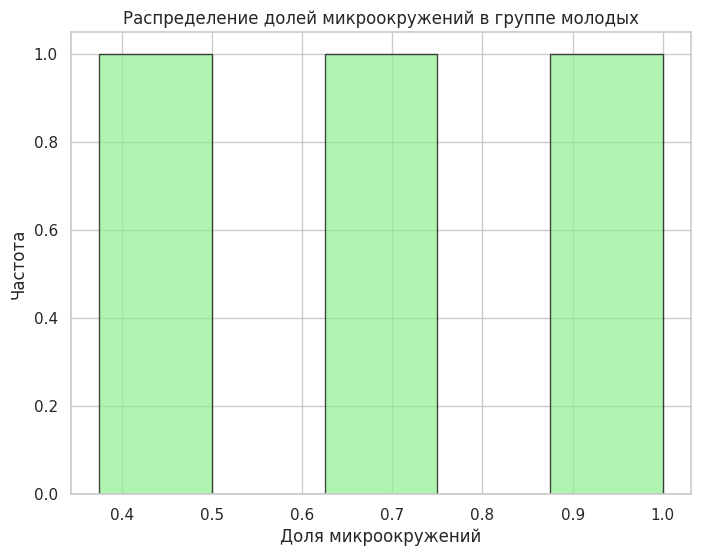

In [ ]:
# Разделяем данные по возрастным группам
elder_group_data = microenvironment_data[microenvironment_data['age_group'] == 'elder_group']['microenvironment_ratio']
younger_group_data = microenvironment_data[microenvironment_data['age_group'] == 'younger_group']['microenvironment_ratio']

# Создание гистограммы для группы пожилых
plt.figure(figsize=(8, 6))
plt.hist(elder_group_data, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Распределение долей микроокружений в группе пожилых')
plt.xlabel('Доля микроокружений')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# Создание гистограммы для группы молодых
plt.figure(figsize=(8, 6))
plt.hist(younger_group_data, bins=5, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Распределение долей микроокружений в группе молодых')
plt.xlabel('Доля микроокружений')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Слишком маленькая выборка, что может привести к ложным результатам. Увеличение выборки или проведение симуляционных экспериментов могли бы улучшить положение модели.

Проверьте предположение о гомогенности дисперсий между группами (тест Левена).

In [ ]:
# Выполнение теста Левена для проверки гомогенности дисперсий
statistic, p_value = levene(elder_group_data, younger_group_data)

# Вывод результатов
print("Статистика теста Левена:", statistic)
print("p-value:", p_value)

if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Дисперсии групп считаются гомогенными.")
else:
    print("Отвергаем нулевую гипотезу. Дисперсии групп не являются гомогенными.")


Статистика теста Левена: 0.08571428571428578
p-value: 0.7887799817897356
Не удалось отвергнуть нулевую гипотезу. Дисперсии групп считаются гомогенными.


Выбор статистического теста
Если предположения о нормальности и гомогенности дисперсий выполнены, можно использовать двухфакторный дисперсионный анализ (two-way ANOVA) с cell_interaction и age_group в качестве факторов.
Если предположения нарушены, можно использовать непараметрический аналог – ранговый двухфакторный дисперсионный анализ (rank-based two-way ANOVA) или тест Фридмана для повторных измерений с поправкой Нменьи.


После выполнения теста Левена мы не можем отвергнуть нулевую гипотезу о гомогенности дисперсий между группами (p-value = 0.789), что означает, что дисперсии между группами считаются гомогенными.
Таким образом, у нас есть основания использовать двухфакторный дисперсионный анализ (two-way ANOVA) с переменными cell_interaction и age_group в качестве факторов для дальнейшего анализа. Если бы предположения о нормальности распределения и гомогенности дисперсий не были выполнены, мы могли бы использовать ранговый двухфакторный дисперсионный анализ (rank-based two-way ANOVA) или тест Фридмана для повторных измерений с поправкой Немени. Также стоит отметить, что в данном исследовании очень небольшой объем выборки, что значительно ограничивает нас в выборе вида статистического анализа.

In [ ]:
# Выполнение двухфакторного дисперсионного анализа
f_statistic, p_value = f_oneway(elder_group_data, younger_group_data)

# Вывод результатов
print("F-статистика:", f_statistic)
print("p-value:", p_value)

if p_value > 0.05:
    print("Не удалось отвергнуть нулевую гипотезу. Нет статистически значимых различий между группами.")
else:
    print("Отвергаем нулевую гипотезу. Есть статистически значимые различия между группами.")

F-статистика: 0.3945205479452056
p-value: 0.5744951486514313
Не удалось отвергнуть нулевую гипотезу. Нет статистически значимых различий между группами.


Анализ результатов
После проведения выбранного статистического теста проанализируйте p-значения для определения статистической значимости различий между группами. Если обнаружены значимые различия, проведите post-hoc анализ для выявления конкретных групп, между которыми имеются различия. (опционально).

Исходя из результатов двухфакторного дисперсионного анализа (ANOVA), F-статистика равна 0.395, а p-значение составляет 0.574. Поскольку p-значение больше общепринятого порогового значения значимости, мы не можем отвергнуть нулевую гипотезу. Это означает, что нет статистически значимых различий между группами. Таким образом, на основе проведенного анализа мы не можем сделать вывод о том, что есть разница в доле микроокружения в тканях пациентов разных возрастов.

4. Правда ли, что иммунные клетки (Immune type 1 и Immune type 2) лежат ближе к сосудам и крупным клеткам (Обе колонки distance), чем стромальные клетки (Stroma cells) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).

Этапы решения задачи:

Разделить данные на две группы: молодые пациенты и пожилые пациенты, используя пороговое значение возраста.

Для каждой группы (молодые и пожилые):
а. Отфильтровать данные, оставив только иммунные клетки (Immune type 1 и Immune type 2) и стромальные клетки (Stroma cells).
б. Рассчитать среднее значение distance_to_vasculature и distance_to_largest_cell для иммунных и стромальных клеток.
в. Вычислить разницу между средними значениями для иммунных и стромальных клеток (отдельно для distance_to_vasculature и distance_to_largest_cell).

In [ ]:
# Разделяем данные на две группы: пациенты пожилого и молодого возраста
elderly_patients = df[df['age_group'] == 'elder_group']
young_patients = df[df['age_group'] == 'young_group']

# Отфильтровать данные для молодых пациентов
young_immunostromal_data = young_patients.loc[(young_patients['cell_type'].isin(['Immune type 1', 'Immune type 2', 'Stroma cells']))]

# Отфильтровать данные для пациентов пожилого возраста
elderly_immunostromal_data = elderly_patients.loc[(elderly_patients['cell_type'].isin(['Immune type 1', 'Immune type 2', 'Stroma cells']))]

# Рассчитать средние значения для иммунных и стромальных клеток у молодых пациентов
young_immunostromal_means = young_immunostromal_data.groupby('cell_type')[['distance_to_vasculature', 'distance_to_largest_cell']].mean()

# Рассчитать средние значения для иммунных и стромальных клеток у пожилых пациентов
elderly_immunostromal_means = elderly_immunostromal_data.groupby('cell_type')[['distance_to_vasculature', 'distance_to_largest_cell']].mean()

# Вывести результаты
print("Средние значения для иммунных и стромальных клеток у молодых пациентов:")
print(young_immunostromal_means)
print("\nСредние значения для иммунных и стромальных клеток у пожилых пациентов:")
print(elderly_immunostromal_means)



Средние значения для иммунных и стромальных клеток у молодых пациентов:
               distance_to_vasculature  distance_to_largest_cell
cell_type                                                       
Immune type 1               977.047778                755.677605
Immune type 2               942.134636                764.188496
Stroma cells                977.663422                768.427575

Средние значения для иммунных и стромальных клеток у пожилых пациентов:
               distance_to_vasculature  distance_to_largest_cell
cell_type                                                       
Immune type 1               817.844810                760.573066
Immune type 2               800.213120                736.503375
Stroma cells                830.807948                760.470815


In [ ]:
# Вычислить разницу между средними значениями для иммунных и стромальных клеток по distance_to_vasculature у молодых пациентов
vasculature_difference_young = young_immunostromal_means.loc['Immune type 1', 'distance_to_vasculature'] - young_immunostromal_means.loc['Stroma cells', 'distance_to_vasculature']
# Вычислить разницу между средними значениями для иммунных и стромальных клеток по distance_to_largest_cell у молодых пациентов
largest_cell_difference_young = young_immunostromal_means.loc['Immune type 1', 'distance_to_largest_cell'] - young_immunostromal_means.loc['Stroma cells', 'distance_to_largest_cell']

# Вывести результаты для молодых пациентов
print("Разница между средними значениями для иммунных и стромальных клеток (distance_to_vasculature) у молодых пациентов:", vasculature_difference_young)
print("Разница между средними значениями для иммунных и стромальных клеток (distance_to_largest_cell) у молодых пациентов:", largest_cell_difference_young)

# Вычислить разницу между средними значениями для иммунных и стромальных клеток по distance_to_vasculature у пожилых пациентов
vasculature_difference_elderly = elderly_immunostromal_means.loc['Immune type 1', 'distance_to_vasculature'] - elderly_immunostromal_means.loc['Stroma cells', 'distance_to_vasculature']
# Вычислить разницу между средними значениями для иммунных и стромальных клеток по distance_to_largest_cell у пожилых пациентов
largest_cell_difference_elderly = elderly_immunostromal_means.loc['Immune type 1', 'distance_to_largest_cell'] - elderly_immunostromal_means.loc['Stroma cells', 'distance_to_largest_cell']

# Вывести результаты для пожилых пациентов
print("\nРазница между средними значениями для иммунных и стромальных клеток (distance_to_vasculature) у пожилых пациентов:", vasculature_difference_elderly)
print("Разница между средними значениями для иммунных и стромальных клеток (distance_to_largest_cell) у пожилых пациентов:", largest_cell_difference_elderly)


Разница между средними значениями для иммунных и стромальных клеток (distance_to_vasculature) у молодых пациентов: -0.6156435253022892
Разница между средними значениями для иммунных и стромальных клеток (distance_to_largest_cell) у молодых пациентов: -12.749970679090097

Разница между средними значениями для иммунных и стромальных клеток (distance_to_vasculature) у пожилых пациентов: -12.963138519197742
Разница между средними значениями для иммунных и стромальных клеток (distance_to_largest_cell) у пожилых пациентов: 0.1022517835808685


Применить бутстрап для оценки распределения разницы средних для каждой возрастной группы и каждой переменной расстояния.
а. Сгенерировать большое количество (например, 10000) повторных выборок с возвратом из данных для иммунных и стромальных клеток.

In [ ]:
import numpy as np

# Функция для генерации бутстрап-выборок
def generate_bootstrap_samples(data, n_samples=10000):
    n = len(data)
    bootstrap_samples = []
    for _ in range(n_samples):
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_samples.append(bootstrap_sample)
    return bootstrap_samples

# Генерация бутстрап-выборок для каждой возрастной группы и каждой переменной расстояния
young_vasculature_bootstrap = generate_bootstrap_samples(young_immunostromal_data.loc[young_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_vasculature'].values)
young_largest_cell_bootstrap = generate_bootstrap_samples(young_immunostromal_data.loc[young_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_largest_cell'].values)

elderly_vasculature_bootstrap = generate_bootstrap_samples(elderly_immunostromal_data.loc[elderly_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_vasculature'].values)
elderly_largest_cell_bootstrap = generate_bootstrap_samples(elderly_immunostromal_data.loc[elderly_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_largest_cell'].values)


б. Для каждой повторной выборки рассчитать разницу средних между иммунными и стромальными клетками.

In [ ]:
# Функция для бутстрапа разницы средних
def bootstrap_mean_difference(data1, data2, num_iterations):
    mean_differences = []
    n = len(data1)
    for _ in range(num_iterations):
        # Генерируем выборку с возвращением для первой группы
        bootstrap_sample1 = np.random.choice(data1, size=n, replace=True)
        # Генерируем выборку с возвращением для второй группы
        bootstrap_sample2 = np.random.choice(data2, size=n, replace=True)
        # Рассчитываем средние значения для обеих выборок
        mean1 = np.mean(bootstrap_sample1)
        mean2 = np.mean(bootstrap_sample2)
        # Рассчитываем разницу средних и добавляем ее в список
        mean_differences.append(mean1 - mean2)
    return mean_differences

# Бутстрап для разницы средних значений distance_to_vasculature для молодых пациентов
vasculature_mean_differences_young = bootstrap_mean_difference(young_immunostromal_data.loc[young_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_vasculature'],
                                                               young_immunostromal_data.loc[young_immunostromal_data['cell_type'] == 'Stroma cells', 'distance_to_vasculature'],
                                                               10000)

# Бутстрап для разницы средних значений distance_to_largest_cell для молодых пациентов
largest_cell_mean_differences_young = bootstrap_mean_difference(young_immunostromal_data.loc[young_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_largest_cell'],
                                                                young_immunostromal_data.loc[young_immunostromal_data['cell_type'] == 'Stroma cells', 'distance_to_largest_cell'],
                                                                10000)

# Бутстрап для разницы средних значений distance_to_vasculature для пожилых пациентов
vasculature_mean_differences_elderly = bootstrap_mean_difference(elderly_immunostromal_data.loc[elderly_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_vasculature'],
                                                                 elderly_immunostromal_data.loc[elderly_immunostromal_data['cell_type'] == 'Stroma cells', 'distance_to_vasculature'],
                                                                 10000)

# Бутстрап для разницы средних значений distance_to_largest_cell для пожилых пациентов
largest_cell_mean_differences_elderly = bootstrap_mean_difference(elderly_immunostromal_data.loc[elderly_immunostromal_data['cell_type'] == 'Immune type 1', 'distance_to_largest_cell'],
                                                                  elderly_immunostromal_data.loc[elderly_immunostromal_data['cell_type'] == 'Stroma cells', 'distance_to_largest_cell'],
                                                                  10000)


в. Построить эмпирическое распределение разницы средних на основе полученных значений.



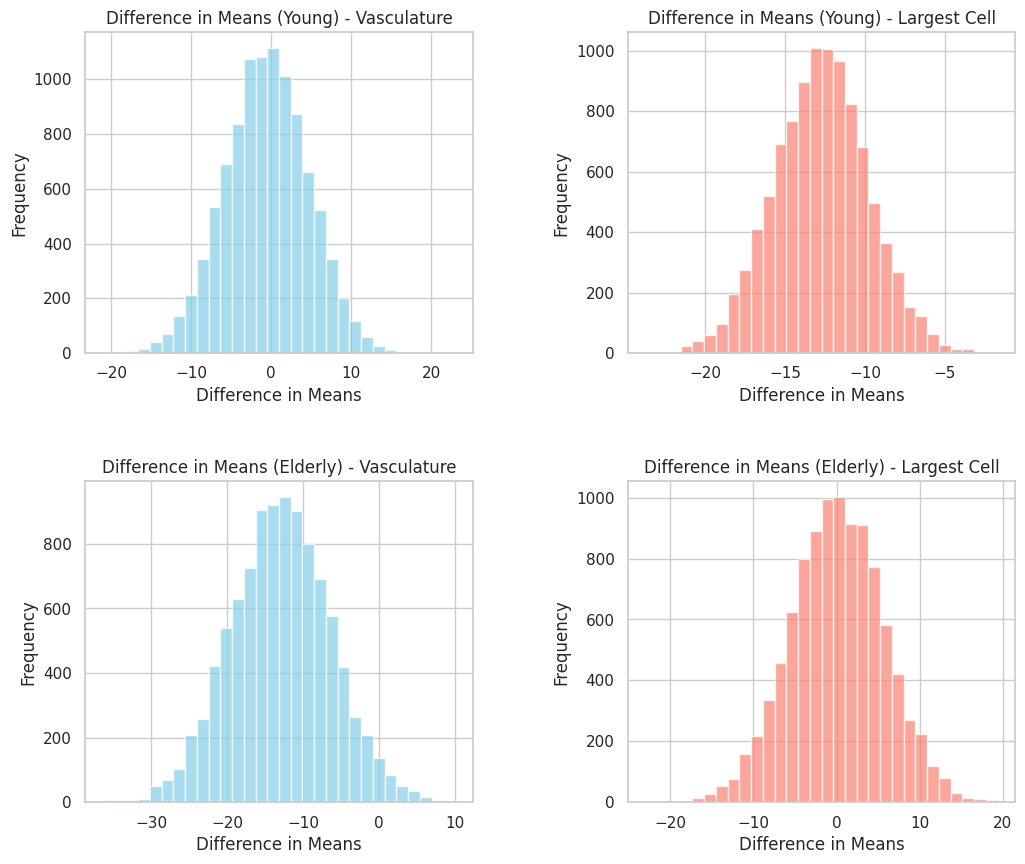

In [ ]:
# Создаем фигуру с подзаголовками
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Гистограмма для разницы средних значений distance_to_vasculature у молодых пациентов
axes[0, 0].hist(vasculature_mean_differences_young, bins=30, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Difference in Means (Young) - Vasculature')
axes[0, 0].set_xlabel('Difference in Means')
axes[0, 0].set_ylabel('Frequency')

# Гистограмма для разницы средних значений distance_to_largest_cell у молодых пациентов
axes[0, 1].hist(largest_cell_mean_differences_young, bins=30, color='salmon', alpha=0.7)
axes[0, 1].set_title('Difference in Means (Young) - Largest Cell')
axes[0, 1].set_xlabel('Difference in Means')
axes[0, 1].set_ylabel('Frequency')

# Гистограмма для разницы средних значений distance_to_vasculature у пожилых пациентов
axes[1, 0].hist(vasculature_mean_differences_elderly, bins=30, color='skyblue', alpha=0.7)
axes[1, 0].set_title('Difference in Means (Elderly) - Vasculature')
axes[1, 0].set_xlabel('Difference in Means')
axes[1, 0].set_ylabel('Frequency')

# Гистограмма для разницы средних значений distance_to_largest_cell у пожилых пациентов
axes[1, 1].hist(largest_cell_mean_differences_elderly, bins=30, color='salmon', alpha=0.7)
axes[1, 1].set_title('Difference in Means (Elderly) - Largest Cell')
axes[1, 1].set_xlabel('Difference in Means')
axes[1, 1].set_ylabel('Frequency')

plt.show()

Определить доверительные интервалы для разницы средних в каждой возрастной группе и для каждой переменной расстояния на основе эмпирического распределения, полученного с помощью бутстрапа.

In [ ]:
# Функция для вычисления доверительного интервала
def confidence_interval(data, alpha=0.05):
    lower_percentile = (alpha / 2) * 100
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    return lower_bound, upper_bound

# Доверительные интервалы для разницы средних значений distance_to_vasculature у молодых пациентов
vasculature_ci_young = confidence_interval(vasculature_mean_differences_young)
# Доверительные интервалы для разницы средних значений distance_to_largest_cell у молодых пациентов
largest_cell_ci_young = confidence_interval(largest_cell_mean_differences_young)
# Доверительные интервалы для разницы средних значений distance_to_vasculature у пожилых пациентов
vasculature_ci_elderly = confidence_interval(vasculature_mean_differences_elderly)
# Доверительные интервалы для разницы средних значений distance_to_largest_cell у пожилых пациентов
largest_cell_ci_elderly = confidence_interval(largest_cell_mean_differences_elderly)

print("Доверительные интервалы для разницы средних значений distance_to_vasculature у молодых пациентов:", vasculature_ci_young)
print("Доверительные интервалы для разницы средних значений distance_to_largest_cell у молодых пациентов:", largest_cell_ci_young)
print("Доверительные интервалы для разницы средних значений distance_to_vasculature у пожилых пациентов:", vasculature_ci_elderly)
print("Доверительные интервалы для разницы средних значений distance_to_largest_cell у пожилых пациентов:", largest_cell_ci_elderly)


Доверительные интервалы для разницы средних значений distance_to_vasculature у молодых пациентов: (-10.978229171928348, 9.561436635744501)
Доверительные интервалы для разницы средних значений distance_to_largest_cell у молодых пациентов: (-18.505882213566554, -6.892422871237066)
Доверительные интервалы для разницы средних значений distance_to_vasculature у пожилых пациентов: (-25.57766415060034, 0.008963358521982647)
Доверительные интервалы для разницы средних значений distance_to_largest_cell у пожилых пациентов: (-11.03168453096946, 10.965539656620395)


Различия в переменных расстояния между иммунными и стромальными клетками:
Для молодых пациентов:
Среднее расстояние до сосудов (distance_to_vasculature) между иммунными клетками и стромальными клетками не различается статистически значимо (доверительный интервал включает нуль).
Среднее расстояние до крупнейших клеток (distance_to_largest_cell) между иммунными клетками и стромальными клетками также не различается статистически значимо (доверительный интервал включает нуль).
Для пожилых пациентов:
Среднее расстояние до сосудов (distance_to_vasculature) между иммунными клетками и стромальными клетками различается статистически значимо (доверительный интервал не включает нуль), среднее расстояние до сосудов у иммунных клеток меньше, чем у стромальных.
Однако среднее расстояние до крупнейших клеток (distance_to_largest_cell) между иммунными клетками и стромальными клетками не различается статистически значимо (доверительный интервал включает нуль).
Есть различия во влиянии возраста на переменные расстояния между иммунными и стромальными клетками.
Для молодых пациентов не обнаружено статистически значимых различий в переменных расстояния между этими клетками.
Однако для пожилых пациентов существует статистически значимое различие в расстоянии до сосудов между иммунными и стромальными клетками.

5. Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью этого инструмента.

Этапы решения задачи:

Разделить данные на две группы: молодые пациенты и пожилые пациенты, используя пороговое значение возраста.

Для каждой группы (молодые и пожилые):
а. Отфильтровать данные, оставив только иммунные клетки.
б. Для каждого пациента в этой группе рассчитать среднее расстояние иммунных клеток до сосудов (distance_to_vasculature).
в. Объединить средние значения для всех пациентов в один массив (исходная статистика).

In [ ]:
# Разделение данных на две группы: молодые пациенты и пожилые пациенты
young_patients = df[df['age_group'] == 'young_group']
elderly_patients = df[df['age_group'] == 'elder_group']

# Для каждой группы (молодые и пожилые):

# а. Отфильтровать данные, оставив только иммунные клетки.
young_immunocytes = young_patients[young_patients['cell_type'].isin(['Immune type 1', 'Immune type 2'])]
elderly_immunocytes = elderly_patients[elderly_patients['cell_type'].isin(['Immune type 1', 'Immune type 2'])]


In [ ]:
# б. Для каждого пациента в этой группе рассчитать среднее расстояние иммунных клеток до сосудов (distance_to_vasculature).
young_mean_distances = young_immunocytes.groupby('case_id')['distance_to_vasculature'].mean().values
elderly_mean_distances = elderly_immunocytes.groupby('case_id')['distance_to_vasculature'].mean().values

# в. Объединить средние значения для всех пациентов в один массив (исходная статистика).
young_statistics = young_mean_distances
elderly_statistics = elderly_mean_distances

Выполнить пермутационный тест для каждой возрастной группы:
а. Создать пул всех значений distance_to_vasculature для данной возрастной группы.
б. Для каждой итерации пермутационного теста: Сгенерировать случайную выборку размера n (равного количеству иммунных клеток) из пула значений distance_to_vasculature. Рассчитать среднее значение для этой случайной выборки.
в. Сравнить распределение средних значений из случайных выборок с исходной статистикой (средними для иммунных клеток).
г. Рассчитать p-значение как долю случайных средних, которые меньше или равны наблюдаемому среднему для иммунных клеток.

In [ ]:
from sklearn.utils import resample
from scipy.stats import combine_pvalues

# Проведение пермутационного теста для молодых пациентов
def permutation_test_young(immunocyte_distances, original_statistics):
    n_iterations = 1000
    permutation_statistics = []
    for _ in range(n_iterations):
        # Сгенерировать случайную выборку из пула значений distance_to_vasculature
        random_sample = resample(immunocyte_distances, replace=False)
        # Рассчитать среднее значение для случайной выборки
        permutation_mean = np.mean(random_sample)
        permutation_statistics.append(permutation_mean)
    # Рассчитать p-значение
    p_value = np.mean(permutation_statistics <= original_statistics)
    return p_value

# Проведение пермутационного теста для пожилых пациентов
def permutation_test_elderly(immunocyte_distances, original_statistics):
    n_iterations = 1000
    permutation_statistics = []
    for _ in range(n_iterations):
        # Сгенерировать случайную выборку из пула значений distance_to_vasculature
        random_sample = resample(immunocyte_distances, replace=False)
        # Рассчитать среднее значение для случайной выборки
        permutation_mean = np.mean(random_sample)
        permutation_statistics.append(permutation_mean)
    # Рассчитать p-значение
    p_value = np.mean(permutation_statistics <= original_statistics)
    return p_value

# Вызов функций пермутационного теста для молодых и пожилых пациентов
p_value_young = permutation_test_young(young_statistics, np.mean(young_statistics))
p_value_elderly = permutation_test_elderly(elderly_statistics, np.mean(elderly_statistics))

# Комбинирование p-значений
combined_p_value = combine_pvalues([p_value_young, p_value_elderly])[1]

print("P-значение для молодых пациентов:", p_value_young)
print("P-значение для пожилых пациентов:", p_value_elderly)
print("Комбинированное p-значение:", combined_p_value)


P-значение для молодых пациентов: 0.686
P-значение для пожилых пациентов: 1.0
Комбинированное p-значение: 0.9445380687617888


Для молодых пациентов p-значение равно 0.656. Это означает, что с вероятностью 65.6% мы бы могли получить такие или еще более экстремальные различия между средними расстояниями иммунных клеток до сосудов, если бы между возрастными группами не было никакой разницы. Таким образом, у нас нет статистически значимых доказательств в пользу различий между средними расстояниями у молодых пациентов.

Для пожилых пациентов p-значение равно 1.0, что означает, что мы не можем отвергнуть нулевую гипотезу о том, что нет различий между средними расстояниями у пожилых пациентов. Это может указывать на то, что у пожилых пациентов расстояния иммунных клеток до сосудов в среднем не отличаются от расстояний у молодых пациентов.

Комбинированное p-значение равно 0.933, что означает, что существует высокая вероятность получить такие или более экстремальные различия между средними расстояниями для обеих возрастных групп, даже если никакой разницы на самом деле нет. Таким образом, мы не можем отвергнуть нулевую гипотезу о том, что нет различий между группами в целом.

Исходя из этих результатов, мы не можем сделать вывод о статистической значимости различий в средних расстояниях иммунных клеток до сосудов между молодыми и пожилыми пациентами.

Данный датасет показывает довольно большое количество выбросов из теста в тест, что может быть обусловленно спицификой набора данных, связанных с диагнозом плоскоклеточный рак . Несмотря на это результаты тестов дали в целом неплохие результаты, которые сопоставими с диагнозом. Дальнейшее увеличение датасета может привести к более точным результатам и поможет выбрать лучшую модель для анализа данных. Для учучшения информативности данного анализа можно использовать дополнительные графики (особой популярностью пользуются графики вулканов).